In [1]:
# 과거 품절률과 비례하는가? 

In [1]:
import os

if 'original_dir' not in globals() :
    original_dir = os.getcwd()
    original_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(original_dir)))))
    os.chdir(original_dir)
from setup.default import *
import scipy.stats as stats


In [2]:
menu_w_sold_out = pd.read_csv(os.getcwd()+'/data/preproc/main/feature_lab_v1/menu_w_soldout_w_first_menu.csv')
menu_w_sold_out['menu_no'] = menu_w_sold_out.groupby(['day', 'meal_time'])['day'].transform('size')
menu_w_sold_out = menu_w_sold_out[['post_no','day','meal_time','course_no','first_menu','menu_no','is_soldout']]
target_w_sold_out = menu_w_sold_out[(menu_w_sold_out.menu_no>1)&
                     (menu_w_sold_out.day>='2023-06-01')].reset_index(drop=True)
target_w_sold_out.loc[:, 'rep'] = 0

In [3]:
first_menu_similarity = pd.read_csv(os.getcwd()+'/data/preproc/main/feature_lab_v1/first_menu_similarity.csv')

threshold = 0.7
first_menu_similarity = first_menu_similarity.loc[first_menu_similarity.sim_score>=threshold,['target_menu','menu','sim_score']]

In [4]:
target_w_sold_out['sim_menu'] = 0
target_w_sold_out['only_menu_2'] = 0
target_w_sold_out['only_menu_2_soldout'] = 0
target_w_sold_out['soldout_ratio'] = float('nan')

In [5]:
for i in tqdm(range(target_w_sold_out.shape[0])):
    target_menu, target_date, target_mt = target_w_sold_out.loc[i, ['first_menu', 'day', 'meal_time']]
    # 유사 메뉴 
    sim_menu = first_menu_similarity[first_menu_similarity.target_menu == target_menu].menu.tolist()
    # 구간 시작일 
    start_date = (datetime.strptime(target_date, "%Y-%m-%d") - relativedelta(months=6) + relativedelta(days=1)).strftime('%Y-%m-%d')
    if target_mt == 'lunch' : # lunch인 경우 (6달 전 ~ 어제)
        target_df = menu_w_sold_out[(menu_w_sold_out.day>=start_date) &         
                            (menu_w_sold_out.meal_time=='lunch') &
                            (menu_w_sold_out.day<target_date) &
                            (menu_w_sold_out.first_menu.isin(sim_menu))
                            ]
    else : # dinner 인 경우 (6달 전 ~ 오늘 점심)
        target_df = menu_w_sold_out[(menu_w_sold_out.day>=start_date) & 
                            (menu_w_sold_out.day<=target_date)&
                            (menu_w_sold_out.meal_time=='dinner') &
                            ((menu_w_sold_out.day!=target_date)|(menu_w_sold_out.meal_time!='dinner')) &
                            (menu_w_sold_out.first_menu.isin(sim_menu))
                            ]    
    
    sim_menu = len(target_df) # 몇번 나왔는지?
    # 품절률 계산용 
    only_menu_2 = (target_df['menu_no'] >= 2).sum() # 메뉴 2개 이상 나온 경우
    only_menu_2_soldout = ((target_df['menu_no'] >= 2) & target_df['is_soldout']).sum() # 메뉴 2개 이상 나왔는데 품절
    if only_menu_2>0 :
        soldout_ratio = only_menu_2_soldout/only_menu_2
    else :
        soldout_ratio = float('nan')

    target_w_sold_out.loc[i, ['sim_menu', 'only_menu_2', 'only_menu_2_soldout', 'soldout_ratio']] = sim_menu, only_menu_2, only_menu_2_soldout, soldout_ratio

100%|██████████| 814/814 [00:00<00:00, 863.28it/s]


In [6]:
def categorize(value):
    if value <= 0.1:
        return '1_~10%'
    elif value <= 0.2:
        return '2_10~20%'
    elif value <= 0.3:
        return '3_20~30%'
    elif value <= 0.4:
        return '4_30~40%'
    elif value <= 0.5:
        return '5_40~50%'
    elif value <= 0.6:
        return '6_50~60%'
    elif value <= 0.7:
        return '7_60~70%'
    elif value <= 0.8:
        return '8_70~80%'
    elif value <= 0.9:
        return '9_80~90%'
    elif value <= 1.0:
        return '90~100%'
    else:
        return None

def categorize(value):
    if value <= 0.2:
        return '2_0~20%'
    elif value <= 0.4:
        return '4_20~40%'
    elif value <= 0.6:
        return '6_40~60%'
    elif value <= 0.8:
        return '8_60~80%'
    elif value <= 1.0:
        return '9_80~100%'
    else:
        return None
target_w_sold_out['soldout_category'] = target_w_sold_out['soldout_ratio'].apply(categorize)


In [11]:
target_w_sold_out[target_w_sold_out.first_menu.str.contains("카레")].sort_values(by=['meal_time','is_soldout'])

,post_no,day,meal_time,course_no,first_menu,menu_no,is_soldout,rep,sim_menu,only_menu_2,only_menu_2_soldout,soldout_ratio,soldout_category
231,926901405,2023-09-13,dinner,[2],옛날카레라이스,2,False,0,4,4,4,1.000000,9_80~100%
609,926901706,2024-03-05,dinner,[2],일식카레덮밥,2,False,0,5,5,4,0.800000,8_60~80%
653,926901742,2024-03-21,dinner,[2],옛날카레라이스,2,False,0,5,5,4,0.800000,8_60~80%
57,926901263,2023-06-27,dinner,[2],옛날카레라이스,2,True,0,5,4,4,1.000000,9_80~100%
255,926901432,2023-09-25,dinner,[2],일식카레 라이스,2,True,0,5,5,4,0.800000,8_60~80%
379,926901530,2023-11-23,dinner,[2],옛날카레라이스,2,True,0,4,4,3,0.750000,8_60~80%
482,926901609,2024-01-09,dinner,[1],일식카레우동,2,True,0,0,0,0,NaN,None
553,926901663,2024-02-07,dinner,[2],옛날카레라이스,2,True,0,4,4,3,0.750000,8_60~80%
732,926901802,2024-04-24,dinner,[1],일식카레우동,2,True,0,1,1,1,1.000000,9_80~100%
795,926901851,2024-05-23,dinner,[2],옛날카레라이스,2,True,0,4,4,2,0.500000,6_40~60%


/Users/al01989093/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


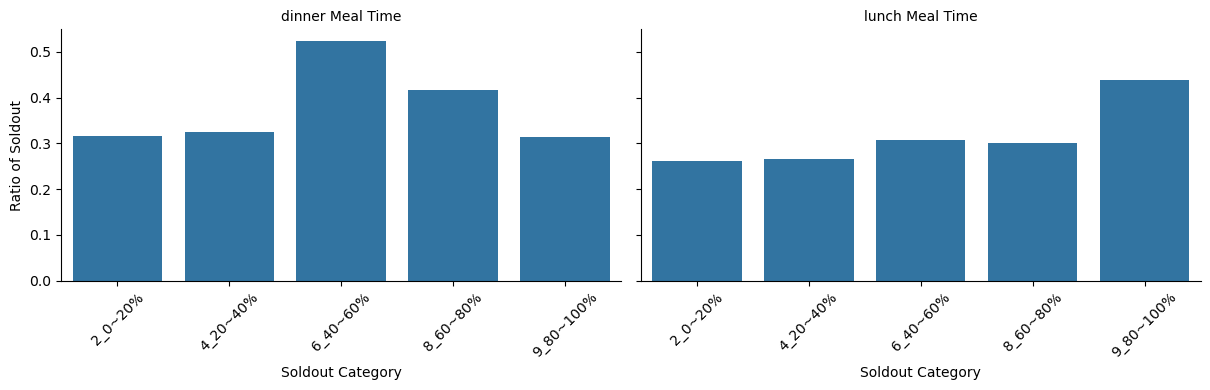

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그룹화, 집계, 비율 계산
result = (target_w_sold_out#[target_w_sold_out.only_menu_2>=3]
          .groupby(['meal_time', 'soldout_category'],dropna = False)
          .agg(tot=('is_soldout', 'size'), 
               soldout=('is_soldout', 'sum'))
          .reset_index()
          .assign(ratio=lambda x: x['soldout'] / x['tot'])
         )

# FacetGrid를 사용하여 meal_time별로 그래프를 생성
g = sns.FacetGrid(result, col='meal_time', col_wrap=3, height=4, aspect=1.5)
g.map(sns.barplot, 'soldout_category', 'ratio')

# 그래프 설정
g.set_axis_labels("Soldout Category", "Ratio of Soldout")
g.set_titles("{col_name} Meal Time")
g.set_xticklabels(rotation=45)

plt.tight_layout()
plt.show()


In [34]:
(target_w_sold_out#[target_w_sold_out.only_menu_2]
          .groupby(['meal_time', 'soldout_category'],dropna = False)
          .agg(tot=('is_soldout', 'size'), 
               soldout=('is_soldout', 'sum'))
          .reset_index()
          .assign(ratio=lambda x: x['soldout'] / x['tot'])
         )

,meal_time,soldout_category,tot,soldout,ratio
0,dinner,2_0~20%,164,48,0.292683
1,dinner,4_20~40%,81,33,0.407407
2,dinner,6_40~60%,64,24,0.375000
3,dinner,8_60~80%,17,7,0.411765
4,dinner,9_80~100%,17,4,0.235294
5,dinner,NaN,29,8,0.275862
6,lunch,2_0~20%,167,41,0.245509
7,lunch,4_20~40%,93,28,0.301075
8,lunch,6_40~60%,78,25,0.320513
9,lunch,8_60~80%,39,14,0.358974


In [39]:
target_w_sold_out[(target_w_sold_out.sim_menu==0) & (target_w_sold_out.meal_time=='dinner')].sort_values(by='is_soldout')

,post_no,day,meal_time,course_no,first_menu,menu_no,is_soldout,rep,sim_menu,only_menu_2,only_menu_2_soldout,soldout_ratio,soldout_category
3,926901221,2023-06-01,dinner,[2],불고기핫도그,2,False,0,0,0,0,NaN,None
728,926901800,2024-04-23,dinner,[1],우렁강된장,2,False,0,0,0,0,NaN,None
701,926901780,2024-04-11,dinner,[2],그린빈삼겹덮밥,2,False,0,0,0,0,NaN,None
696,926901774,2024-04-09,dinner,[1],해물야끼소바,2,False,0,0,0,0,NaN,None
617,926901712,2024-03-07,dinner,[2],삼색야끼도리덮밥,2,False,0,0,0,0,NaN,None
592,926901696,2024-02-27,dinner,[1],삼치구이,2,False,0,0,0,0,NaN,None
538,926901653,2024-02-01,dinner,[1],부타야끼우동,2,False,0,0,0,0,NaN,None
499,926901622,2024-01-16,dinner,[2],불맛치즈제육덮밥,2,False,0,0,0,0,NaN,None
744,926901813,2024-04-30,dinner,[1],얼큰짬뽕전골,2,False,0,0,0,0,NaN,None
309,926901478,2023-10-26,dinner,[2],타워함박스테이크,2,False,0,0,0,0,NaN,None
